In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from psaw import PushshiftAPI
import matplotlib.pyplot as plt
import re

In [4]:
# Initialize API
api = PushshiftAPI()

# Data structure

## Submissions

* In the above example, there are 4657 unique subreddits (== number of subreddit_id's which is great).
* "u_*" subreddits are usually garbage, we have no interest in them, find a way to get rid of them
* There are 12783 unique subscriber counts:
    * Some (most?) subreddits will have different subscriber count every day/hour.

Keeping:

* created_utc
* id
* num_comments
* num_crossposts
* retrieved_on
* score
* selftext
* subreddit
* subreddit_id
* title
* upvote_ratio
* full_link

Not quite sure what these are and whether we should filter (the search) on these:

* is_created_from_ads_ui
    * Promoted posts.
* is_crosspostable.
    * Don't really care about this.
* is_meta
    * No occurances + we don't care about this.  
* is_reddit_media_domain
    * get all, figure out later if it makes sense to keep.
    * When looking at submissions only it might not make sense, but if taking comments than it might be worth it.
* is_robot_indexable
    * is_robot_indexable is False if the post is removed or deleted.
* is_blank    

Filter on (i.e. add as conditions in the request_generator):
* subreddit_subscribers: '>1'
* over_18: False
* is_created_from_ads_ui: False
* is_robot_indexable: True
* is_blank: False
* ?locked: False
* author: '![deleted]'


In [5]:
# Details on what this query actually does below.
# Here using it to figure out what some of the fields are.
# Start and end time will be off by one hour here (not UTC)
# This is fixed in the *Getting the dates right* section

start_time = int(datetime(2021, 6, 7).timestamp())
end_time = int(datetime(2021, 6, 14).timestamp())

api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

sub_recent = pd.DataFrame([submission.d_ for submission in api_request_generator])
sub_recent.shape

(16405, 105)

In [6]:
for f in sub_recent.columns:
    print(f)

all_awardings
allow_live_comments
author
author_flair_css_class
author_flair_richtext
author_flair_text
author_flair_type
author_fullname
author_patreon_flair
author_premium
awarders
can_mod_post
contest_mode
created_utc
domain
full_link
gildings
id
is_created_from_ads_ui
is_crosspostable
is_meta
is_original_content
is_reddit_media_domain
is_robot_indexable
is_self
is_video
link_flair_background_color
link_flair_css_class
link_flair_richtext
link_flair_template_id
link_flair_text
link_flair_text_color
link_flair_type
locked
media_only
no_follow
num_comments
num_crossposts
over_18
parent_whitelist_status
permalink
pinned
pwls
retrieved_on
score
selftext
send_replies
spoiler
stickied
subreddit
subreddit_id
subreddit_subscribers
subreddit_type
thumbnail
title
total_awards_received
treatment_tags
upvote_ratio
url
whitelist_status
wls
created
removed_by_category
suggested_sort
post_hint
preview
edited
url_overridden_by_dest
author_flair_background_color
author_flair_template_id
author_flair

In [61]:
all_sub = np.unique(sub_recent['subreddit'])
print(len(all_sub))

print(len(np.unique(sub_recent['subreddit_id'])))

print(len(np.unique(sub_recent['subreddit_subscribers'])))

4657
4657
12783


In [22]:
sub_recent['subreddit_id'][0]

't5_2usvo'

In [39]:
sub_recent[sub_recent['subreddit'] == '1200isplentyketo']['subreddit_subscribers']

11119    46262
Name: subreddit_subscribers, dtype: int64

In [53]:
sub_recent[sub_recent['subreddit_id'] == 't5_2bzg9t']['subreddit']

78    u_wanderingflower15
Name: subreddit, dtype: object

In [29]:
bla = sub_recent.groupby('subreddit').agg({'subreddit_subscribers': ['mean', 'std']})

In [54]:
bla.sample(20)

subreddit_subscribers            
                                       mean         std
subreddit                                              
Albuquerque                    37012.333333  119.984721
u_SpecialistFold                   0.000000         NaN
Renewable_Energy_News            368.000000    0.000000
MYASSFUCKINGBLOG                 106.000000         NaN
u_Michael_2517                     0.000000         NaN
actuallesbians                336744.500000  256.679762
waterloo                       25726.000000   48.083261
shittynosleep                  37562.000000         NaN
eddit7yearsago                  1064.000000         NaN
AzuraBookClub                   1135.000000         NaN
antidepressants                22729.000000         NaN
gaystoriesgonewild            133628.000000  306.884343
adamsavage                      2691.000000         NaN
promoteonlyfans                60096.500000  213.570441
VancouverIslandJobs              801.000000         NaN
MarvelTheories                 14583.000000         NaN
prodmgmt                        4924.000000         NaN
asktransgender                172015.000000  191.649420
beermoneyph                     8831.000000         NaN
marketing                     351914.888889  461.718920

In [43]:
bla['subreddit_subscribers']['mean'].min()

0.0

In [56]:
no_subscribers = sub_recent[sub_recent['subreddit_subscribers'] == 0]

In [59]:
len(no_subscribers)

1159

In [58]:
for sr in no_subscribers['subreddit']:
    print(sr)

u_wanderingflower15
u_BCjobHub
u_BCjobHub
u_linkdeez_
u_TheLilacClover
u_BCjobHub
u_BCjobHub
u_Any-Middle233
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_agtl
u_randomprincess1
TheRedPill
u_BCjobHub
u_BCjobHub
u_jltlaw80
u_kurtsaltrichter
u_jaseena_digimentor
u_BCjobHub
u_BCjobHub
u_gadilac
u_funeraltemplate
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_ModelFactoryy
MGTOW
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_Crenzi
u_xxxkiwibabyxxx
u_BCjobHub
u_BCjobHub
u_rchrchrls
u_VickyandEvan
u_Mr_HappyJack
u_BCjobHub
u_BCjobHub
u_ALshaibaATLUAE
u_acmerus
u_HtwlawCA476
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_instadw
u_BCjobHub
u_BCjobHub
u_Isadorame_
u_M_nush
u_Angeliana432
u_visalibrarylv
u_scp_459
u_BCjobHub
u_BCjobHub
u_Empathyandkindness22
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_India_Govt_Jobs
u_ModelFactoryy
u_BCjobHub
u_BCjobHub
u_rozeejobspk
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_BCjobHub
u_CostBenKMA
u_BCjobHub
u_BCjobHub
u_eeyeyey636363yey
u_BCjobHub
u_BCjobHub
u_wonder

In [88]:
import re

pattern = r"^u\_"

u_subs = [i for i in all_sub if re.search(pattern,i)]


In [97]:
len(np.unique(no_subscribers['subreddit']))

504

In [95]:
set(no_subscribers['subreddit']) - set(u_subs)

{'MGTOW', 'TheRedPill', 'ificouldtalk2theworld', 'uyieltscertificate'}

In [96]:
set(u_subs) - set(no_subscribers['subreddit'])

set()

In [99]:
# Created (vs created_utc)
sub_recent['created'].head()
sub_recent['created_utc'].head()

0    1.623622e+09
1    1.623621e+09
2    1.623621e+09
3    1.623621e+09
4    1.623621e+09
Name: created, dtype: float64

In [103]:
# Domain (vs subreddit)
sub_recent['domain'].head()
sub_recent['subreddit'].head()

0            self.AskHR
1            self.apple
2    self.LegalAdviceUK
3            self.trees
4    self.relationships
Name: domain, dtype: object

In [105]:
# Upvote ratio (vs score)

sub_recent['upvote_ratio'].head()
sub_recent['score'].head()

0    0.50
1    1.00
2    0.67
3    1.00
4    0.60
Name: upvote_ratio, dtype: float64

In [112]:
# full_link vs url vs permalink
sub_recent[sub_recent['id'] == 'nz8e1e']['full_link']
sub_recent[sub_recent['id'] == 'nz8e1e']['url']
sub_recent[sub_recent['id'] == 'nz8e1e']['permalink']

0    https://www.reddit.com/r/AskHR/comments/nz8e1e...
Name: full_link, dtype: object

In [117]:
sub_recent[sub_recent['id'] == 'nz8e1e']['full_link'] == sub_recent[sub_recent['id'] == 'nz8e1e']['url']

0    True
dtype: bool

In [320]:
def fields_dist(submissions_data):
    '''
    is_created_from_ads_ui
    is_crosspostable
    is_meta
    is_original_content
    is_reddit_media_domain
    is_robot_indexable
    is_self
    is_video
    media_only
    over_18
    '''
    
    fields_dict = dict()
    
    l = len(submissions_data)
    
    fields_dict['is_ads'] = np.sum(submissions_data['is_created_from_ads_ui'])/l
    fields_dict['is_crosspostable'] = np.sum(submissions_data['is_crosspostable'])/l
    fields_dict['is_meta'] = np.sum(submissions_data['is_meta'])/l
    fields_dict['is_original_content'] = np.sum(submissions_data['is_original_content'])/l
    fields_dict['is_reddit_media_domain'] = np.sum(submissions_data['is_reddit_media_domain'])/l
    fields_dict['is_robot_indexable'] = np.sum(submissions_data['is_robot_indexable'])/l
    fields_dict['is_self'] = np.sum(submissions_data['is_self'])/l
    fields_dict['is_video'] = np.sum(submissions_data['is_video'])/l
    fields_dict['media_only'] = np.sum(submissions_data['media_only'])/l
    fields_dict['over_18'] = np.sum(submissions_data['over_18'])/l
    
    for k,v in fields_dict.items():
        print(k,":",round(v,3))
        
    
def show_examples(submission_data):
    
    

In [322]:
fields_dist(sub_recent)

is_ads : 0.003
is_crosspostable : 0.936
is_meta : 0.0
is_original_content : 0.004
is_reddit_media_domain : 0.027
is_robot_indexable : 0.944
is_self : 0.872
is_video : 0.003
media_only : 0.0
over_18 : 0.102


In [121]:
# is_crosspostable
# We don't really care about this
# https://www.reddit.com/r/pushshift/comments/gortnt/about_the_is_crosspostable_attribute/
sub_recent[sub_recent["is_crosspostable"] == False]

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,domain_override,events,eventsOnRender,href_url,is_blank,mobile_ad_url,outbound_link,promoted,show_media,third_party_trackers
1,[],False,Available-Subject-33,None,[],None,text,t2_clhou1m4,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,therealbeezer,None,[],None,text,t2_qs7fn,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,[],False,TheOnionSoupChef,None,[],None,text,t2_b2061mv2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,[],False,Hetalbot,None,[],None,text,t2_7myyv,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16183,[],False,harryg888,None,[],None,text,t2_116s3v,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16203,[],False,pawnh4,None,[],None,text,t2_3mlsxpjx,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16248,[],False,Calm-Honeydew-3573,None,[],None,text,t2_7jiaeq61,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16280,[],False,Meiji___Milk,None,[],None,text,t2_7m9ehkka,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
sub_recent[sub_recent["is_reddit_media_domain"] == True]['selftext']

17                
19                
133               
141      [deleted]
191               
           ...    
16177             
16216             
16327             
16339             
16357             
Name: selftext, Length: 443, dtype: object

In [127]:
sub_recent[sub_recent["is_reddit_media_domain"] == True]['id']

17       nz87zq
19       nz866h
133      nz6p78
141      nz6lum
191      nz5x2k
          ...  
16177    nu0vyy
16216    nu0g6l
16327    ntz06e
16339    ntyww8
16357    ntyomr
Name: id, Length: 443, dtype: object

In [132]:
sub_recent[sub_recent["is_reddit_media_domain"] == True]['num_comments']

17        0
19        2
133       4
141       0
191      22
         ..
16177     2
16216    23
16327    14
16339     4
16357     9
Name: num_comments, Length: 443, dtype: int64

In [141]:
sub_recent[sub_recent["is_meta"] == True]['num_comments']

Series([], Name: num_comments, dtype: int64)

In [136]:
pd.options.display.max_colwidth = 100
(sub_recent[sub_recent['id'] == 'ntz06e']['full_link'])

16327    https://www.reddit.com/r/MST3K/comments/ntz06e/the_hardest_part_of_building_these_3_was_getting/
Name: full_link, dtype: object

In [140]:
pd.options.display.max_colwidth = 200
sub_recent[sub_recent["is_created_from_ads_ui"] == True]['full_link']

2879         https://www.reddit.com/r/u_Turing_com/comments/ny3wmq/are_you_a_software_engineer_living_outside_the_us/
2883         https://www.reddit.com/r/u_Turing_com/comments/ny3vlw/are_you_a_software_engineer_living_outside_the_us/
2891         https://www.reddit.com/r/u_Turing_com/comments/ny3ueg/are_you_a_software_engineer_living_outside_the_us/
2893         https://www.reddit.com/r/u_Turing_com/comments/ny3tpy/are_you_a_software_engineer_living_outside_the_us/
2895         https://www.reddit.com/r/u_Turing_com/comments/ny3ruw/are_you_a_software_engineer_living_outside_the_us/
2898         https://www.reddit.com/r/u_Turing_com/comments/ny3r3e/are_you_a_software_engineer_living_outside_the_us/
2899         https://www.reddit.com/r/u_Turing_com/comments/ny3q1c/are_you_a_software_engineer_living_outside_the_us/
2901         https://www.reddit.com/r/u_Turing_com/comments/ny3pcq/are_you_a_software_engineer_living_outside_the_us/
2902         https://www.reddit.com/r/u_Turing_com/comme

## Comments

* For "jobs | employment" we have \~86,000 comments in one week (~51 comments/hour)
* These belong to 44,894 different submissions.
* Takes a lot longer than submissions search (obv).
* 7284 unique subreddits (same # for subreddit_id).
* From what I can tell, there's no way of filtering nsfw comments when querying.
    * Will have to do after the fact.
    * Check if submission (link_id) is nsfw? 

Keep:

* body
* created_utc
* id
* permalink
* retrieved_on
* score
* subreddit
* subreddit_id
* link_id
* parent_id

Filter on (i.e. add as conditions in the request_generator):
* locked: False
    * This doesn't seem to work, will have to do it in 'post'.
* author: '![deleted],!AutoModerator'

In [7]:
# Details about how this query works etc. below
# Start and end time same as above.
# Again wrong (not utc) - fixed below.

api_request_generator = api.search_comments(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_comments = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_comments['date'] = pd.to_datetime(q_jobs_comments['created_utc'], utc=True, unit='s')
q_jobs_comments.shape

/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


(86403, 40)

In [146]:
for f in q_jobs_comments.columns:
    print(f)

all_awardings
associated_award
author
author_flair_background_color
author_flair_css_class
author_flair_richtext
author_flair_template_id
author_flair_text
author_flair_text_color
author_flair_type
author_fullname
author_patreon_flair
author_premium
awarders
body
collapsed_because_crowd_control
comment_type
created_utc
gildings
id
is_submitter
link_id
locked
no_follow
parent_id
permalink
retrieved_on
score
send_replies
stickied
subreddit
subreddit_id
top_awarded_type
total_awards_received
treatment_tags
created
distinguished
author_cakeday
media_metadata
date


In [156]:
q_jobs_comments['comment_type'][q_jobs_comments['comment_type'] != 'None']

0        None
1        None
2        None
3        None
4        None
         ... 
86398    None
86399    None
86400    None
86401    None
86402    None
Name: comment_type, Length: 86403, dtype: object

In [164]:
bla = [x for x in q_jobs_comments['comment_type'] if x != None]

In [174]:
q_jobs_comments[q_jobs_comments['locked'] == True]['permalink']

28                                  /r/jobs/comments/nz8c2c/jobs_that_pay_20_hourly/h1o70fr/
29        /r/jobs/comments/nz8c1s/is_it_considered_better_to_apply_for_jobs_through/h1o70da/
35          /r/jobs/comments/nz8bls/why_you_should_ask_for_higher_wages_this_summer/h1o6y1j/
93           /r/jobs/comments/nz877n/my_boss_told_me_that_they_cant_fire_me_because/h1o6aa4/
107          /r/jobs/comments/nz86d9/2nd_round_of_interview_for_a_company_whose_job/h1o65dw/
                                                ...                                         
86067        /r/jobs/comments/ntysmx/how_can_someone_with_0_tech_experience_land_an/h0un3ec/
86134        /r/jobs/comments/ntyncj/got_asked_for_references_after_accepting_offer/h0um5ya/
86186          /r/Fallout76Marketplace/comments/ntyiiq/xb1_h_combat_rifles_w_offers/h0ulcxi/
86374         /r/jobs/comments/nty38q/any_college_students_have_recommendations_for/h0uit0q/
86402    /r/jobs/comments/nty1hv/success_and_disappointment_megathread

In [176]:
q_jobs_comments[q_jobs_comments['locked'] == True]['body']

28       Hello, thank you for posting to r/Jobs! \n\nWe just wanted to let you know that we have a new [discord server, come join the chat!](https://discord.gg/TY6ErXV)\n\n*I am a bot, and this action was ...
29       Hello, thank you for posting to r/Jobs! \n\nWe just wanted to let you know that we have a new [discord server, come join the chat!](https://discord.gg/TY6ErXV)\n\n*I am a bot, and this action was ...
35       Hello, thank you for posting to r/Jobs! \n\nWe just wanted to let you know that we have a new [discord server, come join the chat!](https://discord.gg/TY6ErXV)\n\n*I am a bot, and this action was ...
93       Hello, thank you for posting to r/Jobs! \n\nWe just wanted to let you know that we have a new [discord server, come join the chat!](https://discord.gg/TY6ErXV)\n\n*I am a bot, and this action was ...
107      Hello, thank you for posting to r/Jobs! \n\nWe just wanted to let you know that we have a new [discord server, come join the chat!](https://discord.gg/TY6E

* 7284 unique subreddits (same # for subreddit_id).

In [179]:
len(np.unique(q_jobs_comments['subreddit']))
len(np.unique(q_jobs_comments['subreddit_id']))

7284

In [8]:
len(np.unique(q_jobs_comments['link_id']))

44894

In [181]:
len(np.unique(q_jobs_comments['parent_id']))

74349

In [185]:

np.unique(q_jobs_comments['treatment_tags'])


array([list([]), list(['econ:render:lottie:bulb']),
       list(['econ:render:lottie:redstar']),
       list(['econ:render:lottie:sunny2'])], dtype=object)

## Submissions and comments

* The two endpoints (search_submissions and search_comments) are searching completely different spaces (subs vs comments).
* Using the above examples:
    * \~80% of submissions are not present in the comments (i.e. none of the comments returned have been made in response to these posts)
    * \~92% of submissions linked to the comments returned by search_comments endpoint are not in the submissions returned by the search_submissions endpoint.
* So there's three immediately apparent ways of putting together a dataset for further analysis:

    1. Submissions only 
    2. Comments only
    3. Submissions + comments associated with those submissions (N.B.: This is different than just combining 1 and 2).

In [9]:
sub_recent['id'].head()

0    nz8e1e
1    nz8cdz
2    nz8cbd
3    nz8c8e
4    nz8c2h
Name: id, dtype: object

In [10]:
q_jobs_comments['link_id'].head()

0    t3_nz2sx9
1    t3_nz64jx
2    t3_nz882f
3    t3_nz2sx9
4    t3_nywjgk
Name: link_id, dtype: object

In [16]:
link_ids = [x.split('_')[1] for x in np.unique(q_jobs_comments['link_id'])]

In [18]:
sub_ids = sub_recent['id']

In [24]:
len(set(sub_ids) - set(link_ids))/len(sub_ids)

0.7853703139286803

In [25]:
len(set(link_ids) - set(sub_ids))/len(link_ids)

0.9215708112442643

# Getting all submissions with more than a certain upvote score

In [5]:
# Initialize API
api = PushshiftAPI()

# Set up generator to make API request.
api_request_generator = api.search_submissions(subreddit='news', score = ">2000")

# Make the request and collect results into a pd.DataFrame
news_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

# Shape (n_results, n_features)
news_submissions.shape

In [19]:
# Available features
news_submissions.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'edited', 'full_link', 'gilded', 'gildings',
       'id', 'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_received',
       'treatment_ta

In [ ]:
api.

In [17]:
# Transform to datetime
news_submissions['date'] = pd.to_datetime(jokes_submissions['created_utc'], utc = True, unit = 's')
news_submissions[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
747,2019-07-24 03:28:46+00:00,"My best friend called me and said ""An evil wiz...",12514,117,I drove all the way to his house just to find ...
822,2019-07-10 09:43:25+00:00,I went to the liquor store on my bicycle and b...,6395,93,\n\n...'cause I fell 7 times on the way home...
161,2020-04-15 14:42:22+00:00,Husband doing crossword with his wife,2528,132,"\n\nHusband: Emphatic no, five letters.\n\nWi..."
1312,2019-04-18 20:13:24+00:00,The girl with no arms and legs laying by the pool,9047,238,There’s a girl with no arms and legs laying by...
5600,2016-12-21 09:12:29+00:00,Break ups are the worst in China...,3047,180,You see her face everywhere.
2864,2018-04-05 16:00:16+00:00,I asked my girlfriend to describe me in 5 words.,34538,537,"She said I'm mature, I'm moral, I'm pure, I'm ..."
5254,2017-02-18 22:10:34+00:00,Two blind pilots enter a plane,4247,100,They have sunglasses and white sticks. As the ...
2569,2018-05-19 15:06:42+00:00,Don't ever underestimate a Scottish police off...,5240,144,A London lawyer runs a stop sign and gets pull...
3232,2018-02-12 05:04:36+00:00,Afternoon Sex,36740,663,"The only way to pull off a Sunday afternoon ""q..."
711,2019-07-30 11:44:48+00:00,I once dated a girl who had a twin.,22951,356,People kept asking me how I could tell them ap...


# Getting submission based on search keyword

Searching comments is done in the same way, but using api.search_comments instead of api.search_submissions

In [28]:
# Set up generator to make API request.
api_request_generator = api.search_submissions(q='(jobs | employment)', score = '>2000')

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

q_jobs_submissions['date'] = pd.to_datetime(q_jobs_submissions['created_utc'], utc=True, unit='s')

q_jobs_submissions.shape

(4645, 102)

In [29]:
q_jobs_submissions[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
115,2020-07-21 18:38:33+00:00,Aita for calling out my sister after she shame...,12490,1036,I’m 28 my sister is 26. She got married three ...
2041,2018-03-05 16:21:16+00:00,TIL Before he was a famous musician Johnny Cas...,32066,499,
3571,2016-10-09 18:06:11+00:00,My boyfriend and I started a business out of h...,3612,2867,Hi Reddit! I’m Monique. Two years ago I was wo...
3687,2016-07-24 12:55:42+00:00,EMSK the most popular resumes are either chron...,2039,54,[deleted]
3202,2017-01-26 12:45:34+00:00,Keystone pipeline will create just 35 permanen...,31452,3040,
577,2019-08-15 07:08:55+00:00,Video Game Developer Insight on EA's Relations...,2581,460,I've been a video game developer for near thre...
1973,2018-03-23 15:14:04+00:00,I work as a companion to a man who has Down sy...,3045,251,His Individual Support Plan allows for no alon...
687,2019-07-19 10:47:41+00:00,Fine! But you're stealing their jobs!,3068,163,I love Target. I'm also a stress eater who hap...
3446,2016-11-30 00:42:18+00:00,You are only a Temp!,3459,253,So in my time out of tech support from the lig...
3683,2016-07-26 04:35:07+00:00,Ken M On Six-Figure Jobs,3944,163,


In [30]:
max(q_jobs_submissions['date'])

Timestamp('2021-06-14 02:29:15+0000', tz='UTC')

In [ ]:
# Collect submissions/comments within a certain period

In [3]:
start_time = int(datetime(2020, 10, 23).timestamp())
end_time = int(datetime(2020, 10, 26).timestamp())

api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions.shape

(6205, 99)

In [5]:
start_time = int(datetime(2020, 10, 23).timestamp())
end_time = int(datetime(2020, 10, 26).timestamp())

api_request_generator2 = api.search_submissions(q='(jobs OR employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_submissions2 = pd.DataFrame([submission.d_ for submission in api_request_generator2])
q_jobs_submissions2.shape

(65, 71)

In [11]:
q_jobs_submissions['date'] = pd.to_datetime(q_jobs_submissions['created_utc'], utc=True, unit='s')
q_jobs_submissions[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
1630,2020-10-25 03:22:31+00:00,I’m addicted to caffeine pills,1,16,I probably take 1000mg-1400mg is caffeine a da...
4054,2020-10-23 21:50:56+00:00,Question about gaps after a foundation program...,1,4,"Hello, I wanna ask about a gap in trade.\n\nI'..."
5805,2020-10-23 03:14:45+00:00,HOW THIS WORKS...,1,0,\n* Website of the course: https://LinuxUpskil...
5259,2020-10-23 10:29:21+00:00,Revamp your problems by the help of real black...,1,0,&amp;#x200B;\n\n[ ](https://preview.redd.it/t...
5724,2020-10-23 03:54:07+00:00,Scrapping together a network,1,5,So I got a bunch of gear that our shop has acc...
2594,2020-10-24 16:20:41+00:00,Our new home. ♥️ It’s about 400 years old. We ...,1,34,
1979,2020-10-24 22:44:32+00:00,Can you get the full maternity EI amount over ...,1,8,Let's say maternity EI pays you 500 a week for...
1034,2020-10-25 12:58:31+00:00,"Amateur &amp; POV doggy, anal, blow jobs, cum ...",1,2,
5072,2020-10-23 12:37:24+00:00,What exactly does the 'Check Access' button in...,1,3,Hello all\n\nWe are having trouble with device...
3810,2020-10-24 00:26:20+00:00,The job market seriously stinks,1,8,I enlisted in the Air Force at the start of th...


In [ ]:
q_jobs_submissions['selftext', 'subreddit'][5805]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 611
Traceback (most recent call last):
  File "/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: ('selftext', 'subreddit')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.u

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: ('selftext', 'subreddit')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-026950f2ef79>", line 1, in <module>
    q

In [7]:
q_jobs_submissions2['date'] = pd.to_datetime(q_jobs_submissions2['created_utc'], utc=True, unit='s')
q_jobs_submissions2[['date','title', 'score', 'num_comments', 'selftext']].sample(20)

,date,title,score,num_comments,selftext
27,2020-10-24 18:22:02+00:00,Do I have to list ALL past employment on appli...,1,12,I am 29 and applying for law school for the fi...
21,2020-10-25 01:52:09+00:00,Why are so many people relying on a stimulus?,1,202,This is not meant to be demeaning or insulting...
45,2020-10-23 19:46:58+00:00,I never thought I could hate someone so much.,1,2,My belief that being friends with an ex is ver...
41,2020-10-23 23:36:18+00:00,35 [M4F] I want to turn you into white trash,1,0,"Have you ever wanted to just ""let go""? To sto..."
16,2020-10-25 08:08:50+00:00,I'm a public policy analyst that has dedicated...,1,9,"Hey peeps,\n\nMy name is Tudor! By trade, I a..."
4,2020-10-25 20:25:33+00:00,"Was super excited about finally getting a job,...",1,0,I don’t even know how to start with this. Apol...
10,2020-10-25 15:59:03+00:00,Hi there. I'm thinking of applying to the Robe...,1,3,Hi there. I'm thinking of applying to the Robe...
43,2020-10-23 21:55:57+00:00,"Moving to Winnipeg from Edmonton, what is the ...",1,21,I currently work for the Government of Alberta...
44,2020-10-23 20:18:48+00:00,prop 22,1,13,Disclaimer: I'm sorry if this does not belong ...
48,2020-10-23 16:45:32+00:00,[HIRING] Research Data Analyst at University o...,1,0,"University of California, Riverside is looking..."


In [13]:
q_jobs_submissions2['selftext'][45]

'My belief that being friends with an ex is very rare, and even in those rarities there are many attempting to be friends and haven’t quite realized the ship they’re trying to salvage is already sunk. \n\nI happen to be in one of these situations. At this point the only options is ghosting, as bad as it sounds, it is the only healthy choice. I’m not the greatest person in the world I may even share some of the Narc traits my ex has, it could be one of the biggest reasons I feel I hate her. But it’s not the only reason by a long shot.\n\nShe’s reached out and I have reached out when I know I shouldn’t have. Anytime we connect now it’s usually me who starts an argument because shes doing and saying the same things that added to our inviability. She starts complaining about someone making her feel a certain way, there’s something for her to complain about constantly, and she still talks about her ex, comparing me to him, and I’m sitting there like wait wtf I don’t have to listen to any of

# Getting comments

In [48]:
api_request_generator = api.search_comments(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_comments = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_comments['date'] = pd.to_datetime(q_jobs_comments['created_utc'], utc=True, unit='s')
q_jobs_comments.shape

(35706, 39)

In [51]:
q_jobs_comments.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'created', 'distinguished', 'edited', 'author_cakeday', 'date'],
      dtype='object')

In [ ]:
q_jobs_comments[['date', 'score', 'body', 'parent_id']].sample(20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 612
Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-cd530e1fd048>", line 1, in <module>
    q_jobs_comments[['date', 'score', 'body', 'parent_id']].sample(20)
NameError: name 'q_jobs_comments' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/munchausend/.local/lib/python3.7/site-packages/IPytho

# Getting comments for specific submissions

* There will often be a discrepancy bewtween a submission's 'num_comments' feature and the number of comments retrieved using the search_comments API
    * Depends on when each was indexed, whether a comment was removed/deleted, etc.
    * The number of comments retrieved using the search_comments endpoint are more accurate + are the actual number of comments we have access to.
*     

In [229]:
sub_ids = sub_recent['id']
test_ids = list(sub_ids[:200])

In [291]:
api_request_generator = api.search_comments(link_id = test_ids,
                                              after = start_time,
                                              before = end_time,
                                              limit = 1000,
#                                               reply_delay = '>30',
#                                               locked = True,
                                              author = '![deleted],!AutoModerator' # 'AutoModerator'
                                           )

q_jobs_comments = pd.DataFrame([submission.d_ for submission in api_request_generator])
# q_jobs_comments['date'] = pd.to_datetime(q_jobs_comments['created_utc'], utc=True, unit='s')
# q_jobs_comments.shape

In [286]:
q_jobs_comments.head()

,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,created,distinguished,author_cakeday
0,[],None,Obreezey,None,None,[],None,None,None,text,...,True,False,relationship_advice,t5_2r0cn,None,0,[],1.623622e+09,NaN,NaN
1,[],None,jim1188,None,None,[],None,None,None,text,...,True,False,PersonalFinanceCanada,t5_2tasy,None,0,[],1.623622e+09,NaN,NaN
2,[],None,Back41DayOnly,None,None,[],None,None,None,text,...,True,False,amcstock,t5_3sulg5,None,0,[],1.623622e+09,NaN,NaN
3,[],None,fallof69,None,None,[],None,None,None,text,...,True,False,SCWives,t5_tszgr,None,0,[],1.623622e+09,NaN,NaN
4,[],None,confusedbrownbae,None,None,[],None,None,None,text,...,True,False,self,t5_2qh96,None,0,[],1.623622e+09,NaN,NaN


In [292]:
# AutoModerator.
q_jobs_comments[q_jobs_comments['author'] == 'AutoModerator']

,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,created,distinguished,author_cakeday


In [293]:
# AutoModerator.
q_jobs_comments[q_jobs_comments['author'] == '[deleted]']

,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,created,distinguished,author_cakeday


In [181]:
q_jobs_comments['link_id']

0    t3_nz89xq
1    t3_nz8b7h
2    t3_nz8b63
3    t3_nz8cbd
4    t3_nz8c8e
5    t3_nz8c2c
6    t3_nz8c1s
7    t3_nz8bls
8    t3_nz89xq
9    t3_nz866h
Name: link_id, dtype: object

In [126]:
# How many link_ids are in the actual payload and which ones are missing?
test_link_ids = [x.split('_')[1] for x in np.unique(q_jobs_comments['link_id'])]
s = set(test_ids) - set(test_link_ids)
print(len(s))
print(s)



11
{'nz89am', 'nz8b48', 'nz8cdz', 'nz88s8', 'nz88i1', 'nz88sc', 'nz8c2h', 'nz8amb', 'nz87ou', 'nz8e1e', 'nz87zq'}


In [142]:
sub_recent[sub_recent['id'] == test_ids[0]]['num_comments']

0    6
Name: num_comments, dtype: int64

In [64]:
sub_recent[sub_recent['id'] == test_ids[1]]['num_comments']

1    0
Name: num_comments, dtype: int64

In [102]:
sub_recent[sub_recent['id'] == test_ids[2]]['num_comments']

2    4
Name: num_comments, dtype: int64

In [66]:
sub_recent[sub_recent['id'] == test_ids[3]]['num_comments']

3    2
Name: num_comments, dtype: int64

In [67]:
sub_recent[sub_recent['id'] == test_ids[4]]['num_comments']

4    20
Name: num_comments, dtype: int64

In [195]:
pd.options.display.max_colwidth = 200
sub_recent[sub_recent['id'] == 'nz8cbd']['full_link']

2    https://www.reddit.com/r/LegalAdviceUK/comments/nz8cbd/unsure_what_was_on_my_old_employment_contract_now/
Name: full_link, dtype: object

In [198]:
sub_recent[sub_recent['id'] == 'nz8cbd']['selftext']

2    I work in an independent pub in Cornwall. When I started I signed some forms on my first day and stupidly did not take a copy. \n\nAfter I recently asked to see my existing contract, I was told co...
Name: selftext, dtype: object

In [224]:
bla = sub_recent[sub_recent['is_robot_indexable'] == False]

In [226]:
bla[bla['author'] == '[deleted]']

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,domain_override,events,eventsOnRender,href_url,is_blank,mobile_ad_url,outbound_link,promoted,show_media,third_party_trackers
43,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14650,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14671,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15209,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15523,[],False,[deleted],None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
q_jobs_comments[q_jobs_comments['author'] == '[deleted]']

,all_awardings,approved_at_utc,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,score,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,created,author_cakeday
17,[],None,None,[deleted],,None,NaN,None,None,dark,...,1,True,False,CryptoMoonShots,t5_9e4pv,None,0,[],1.623621e+09,NaN
21,[],None,None,[deleted],,None,NaN,None,None,dark,...,1,True,False,CryptoMoonShots,t5_9e4pv,None,0,[],1.623621e+09,NaN
22,[],None,None,[deleted],,None,NaN,None,None,dark,...,1,True,False,CryptoMoonShots,t5_9e4pv,None,0,[],1.623621e+09,NaN
27,[],None,None,[deleted],,None,NaN,None,None,dark,...,1,True,False,CryptoMoonShots,t5_9e4pv,None,0,[],1.623621e+09,NaN
32,[],None,None,[deleted],,None,NaN,None,None,dark,...,1,True,False,CryptoMoonShots,t5_9e4pv,None,0,[],1.623621e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,[],None,None,[deleted],,None,NaN,None,None,dark,...,97,True,False,collapse,t5_2qhw9,None,0,[],1.623618e+09,NaN
471,[],None,None,[deleted],,None,NaN,None,None,dark,...,2,True,False,AmItheAsshole,t5_2xhvq,None,0,[],1.623616e+09,NaN
472,[],None,None,[deleted],,None,NaN,None,None,dark,...,239,True,False,AmItheAsshole,t5_2xhvq,None,0,[],1.623616e+09,NaN
516,[],None,None,[deleted],,None,NaN,None,None,dark,...,1,True,False,MbtiTypeMe,t5_m1ah5,None,0,[],1.623615e+09,NaN


In [ ]:
## G

## Filtering

In [42]:
api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time, 
                                              filter=['url','author', 'title', 'subreddit'],
                                              limit = 10000)

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions.shape

/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/munchausend/opt/anaconda3/envs/redditScrapper/lib/python3.7/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


(6205, 6)

In [ ]:
q_jobs_submissions.columns

The files that are returned can be filtered by adding ```filter = ['field1','field2']``` in the 

## Submission & comments

In [14]:
start_time = int(datetime(2020, 10, 23).timestamp())
end_time = int(datetime(2020, 10, 26).timestamp())

api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions.shape

(6205, 99)

In [92]:
api_request_generator = api.search_submissions(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time, 
                                              score = ">1")

q_jobs_submissions2 = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions2.shape

(8, 66)

In [95]:
api_request_generator = api.search_submissions(q='(employment)',
                                              after = start_time,
                                              before = end_time, 
                                              score = ">1")

q_jobs_submissions2 = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_submissions2.shape

(0, 0)

In [5]:
api_request_generator = api.search_comments(q='(jobs | employment)',
                                              after = start_time,
                                              before = end_time)

q_jobs_comments = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_comments['date'] = pd.to_datetime(q_jobs_comments['created_utc'], utc=True, unit='s')
q_jobs_comments.shape

(35706, 40)

In [6]:
q_jobs_comments.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'created', 'distinguished', 'edited', 'author_cakeday', 'date'],
      dtype='object')

In [66]:
submission_ids = q_jobs_submissions['id']
comment_parent_ids = q_jobs_comments['parent_id']
comment_link_ids = q_jobs_comments['link_id']

In [35]:
len(set(comment_parent_ids) - set(comment_link_ids))

20723

In [36]:
len(set(comment_link_ids) - set(comment_parent_ids))

8419

In [39]:
comment_parent_ids.sample(20)

21325    t1_g9tuw82
4516     t1_ga2hj5f
25752    t1_g9rfglv
23539    t1_g9snrtz
17030     t3_jgwv0u
13691     t3_jhecjb
9554     t1_g9zsrj7
7050      t3_jhr6l0
22168     t3_jgya81
8502     t1_g9z2jql
19892    t1_g9u9a0w
83        t3_jh9dhm
28912    t1_g9r8odr
24547     t3_jgspm0
30489     t3_jgjrof
9085     t1_ga01hrn
22397    t1_g9s50eo
20898     t3_jgzwf7
33499    t1_g9kpy3v
15320    t1_g9wvxar
Name: parent_id, dtype: object

In [40]:
comment_link_ids.sample(20)

17511    t3_jh2ddd
11328    t3_jh5y1y
15283    t3_jhb1qu
4506     t3_jh7rkj
23812    t3_jgq2v8
18034    t3_jh66pe
14889    t3_jh6qga
13144    t3_jh1sif
7043     t3_jhppl3
25579    t3_jgse4d
21581    t3_jgz9bo
12743    t3_jhbkz4
32135    t3_jgf6bl
5421     t3_jh7u4w
21485    t3_jgej3a
21607    t3_jgz4zn
13745    t3_jh7yav
16103    t3_jh6yw9
3793     t3_jhx5my
28909    t3_jgky0e
Name: link_id, dtype: object

Will use link_id to actually link comments to submissions.
>link_id is the submission. parent_id is the parent of the comment. It could be another comment or it could be the submission if the comment is a top level comment

Will have to get submissions first, and then search for comments using that id (```link_id```) and then merge the data.

In [58]:
submission_ids[0]

'ji45jg'

In [59]:
api_request_generator = api.search_comments(link_id = submission_ids[0])

q_jobs_comments_1 = pd.DataFrame([submission.d_ for submission in api_request_generator])
q_jobs_comments_1['date'] = pd.to_datetime(q_jobs_comments_1['created_utc'], utc=True, unit='s')
q_jobs_comments_1.shape

(1, 44)

In [60]:
q_jobs_comments_1

,all_awardings,approved_at_utc,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,score,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,created,date
0,[],None,None,Snoogins828,None,None,[],None,None,None,...,1,True,False,chiropractorzone,t5_hx57l,None,0,[],1.603721e+09,2020-10-26 15:01:25+00:00


In [86]:
q_jobs_submissions['num_comments']

0        1
1        0
2       10
3        9
4        0
        ..
6200    13
6201     1
6202     8
6203     5
6204     2
Name: num_comments, Length: 6205, dtype: int64

In [16]:
def plotMetrics(submissions_data):
    
    fig,ax = plt.figure(figsize=(12,12))
    plt.hist(submissions_data['num_comments'])       

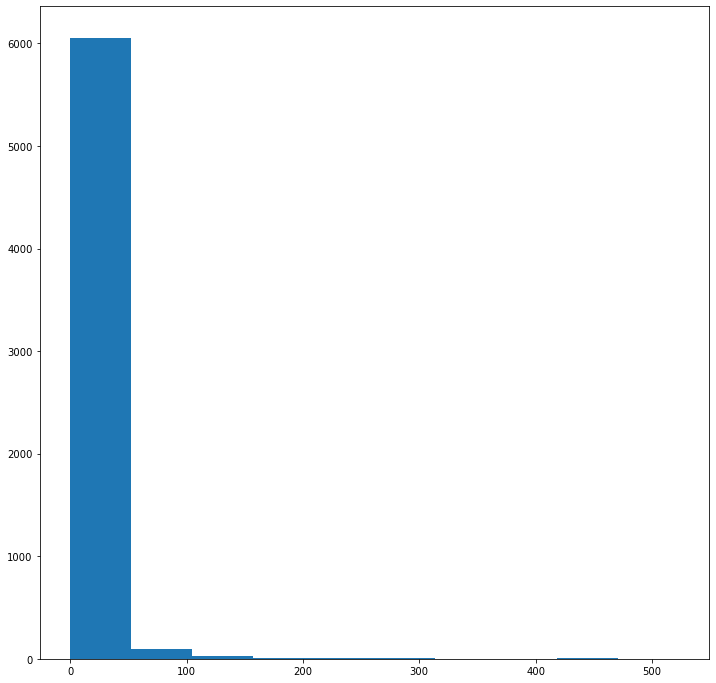

In [17]:
plotMetrics(q_jobs_submissions) 

## Getting the dates right

In [ ]:
surveyPeriods = pd.read_excel('/Volumes/Survey_Social_Media_Compare/Methods/Scripts/Surveys/table_details/surveyPeriods.xlsx', sheet_name='AI+HPS')

**The actual query needs to be made with a utc timestamp**

In [307]:
def to_utc_timestamp(date_ts):
    '''

    Parameters:
        date_ts (Timestamp): 

    Returns:
        date (datetime): A datetime object  
    '''

    dateDT = date_ts.replace(tzinfo = timezone.utc).timestamp()
    
    return dateDT


def weekFromDay(day):
    '''
    Work the week starting and ending dates given any date.
    Params:
        day (datetime): Can be a Timestamp (pandas/numpy object) or a datetime.datetime object.

    Returns: 
        weekStart (Timestamp): The date corresponding to the start (i.e. Monday) of the date specified by *day* param.
        weekEnd (Timestamp): The date corresponding to the end (i.e. Sunday) of the date specified by *day* param.
    '''

    weekStart = day - timedelta(days=day.weekday())
    weekEnd = weekStart + timedelta(days=6)

    return weekStart.strftime('%Y-%m-%d'), weekEnd.strftime('%Y-%m-%d')


def nextMonday(date):
#     date = toDatetime(date)

    date_dt = datetime.strptime(date, "%Y-%m-%d")

    nextM = date_dt + timedelta(days=-date_dt.weekday(), weeks=1)

    return nextM

def surveyDates(surveyPeriods):


    # Load survey periods
#     surveyPeriods = pd.read_excel('/Volumes/Survey_Social_Media_Compare/Methods/Scripts/Surveys/table_details/surveyPeriods.xlsx', sheet_name='AI+HPS')

    # Generate tuple of week start and end dates based on the collection dates in the Axios/Ipsos survey. 
    AI_weeks = [weekFromDay(date) for date in surveyPeriods['A_I_start_date']]


    # Get first monday and last sunday from the A/I data collection periods
    firstDate,_ = weekFromDay(surveyPeriods['A_I_start_date'][0])
    _, lastDate = weekFromDay(surveyPeriods['A_I_start_date'].iloc[-1])

    # Create data ranges for all mondays/sundays starting with the first one covered in A/I.
    mondays = pd.date_range(firstDate, lastDate, freq='W-MON')
    leading_mondays = pd.date_range(nextMonday(firstDate), nextMonday(lastDate), freq='W-MON')

    # Get strings
    mondays_str = mondays.strftime('%Y-%m-%d')
    leading_mondays_str = leading_mondays.strftime('%Y-%m-%d')

    # Saving all the results in a tuple
    all_weeks_utc = [(to_utc_timestamp(m), to_utc_timestamp(s)) for m, s in zip(mondays, leading_mondays)]
    all_weeks_str = [(m, s) for m, s in zip(mondays_str, leading_mondays_str)]
    
    return all_weeks_utc, all_weeks_str

In [308]:
all_weeks_utc, all_weeks_str = surveyDates(surveyPeriods)

In [309]:
all_weeks_utc

[(1603065600.0, 1603670400.0),
 (1603670400.0, 1604275200.0),
 (1604275200.0, 1604880000.0),
 (1604880000.0, 1605484800.0),
 (1605484800.0, 1606089600.0),
 (1606089600.0, 1606694400.0),
 (1606694400.0, 1607299200.0),
 (1607299200.0, 1607904000.0),
 (1607904000.0, 1608508800.0),
 (1608508800.0, 1609113600.0),
 (1609113600.0, 1609718400.0),
 (1609718400.0, 1610323200.0),
 (1610323200.0, 1610928000.0),
 (1610928000.0, 1611532800.0),
 (1611532800.0, 1612137600.0),
 (1612137600.0, 1612742400.0),
 (1612742400.0, 1613347200.0),
 (1613347200.0, 1613952000.0),
 (1613952000.0, 1614556800.0),
 (1614556800.0, 1615161600.0),
 (1615161600.0, 1615766400.0),
 (1615766400.0, 1616371200.0),
 (1616371200.0, 1616976000.0),
 (1616976000.0, 1617580800.0),
 (1617580800.0, 1618185600.0),
 (1618185600.0, 1618790400.0),
 (1618790400.0, 1619395200.0),
 (1619395200.0, 1620000000.0),
 (1620000000.0, 1620604800.0),
 (1620604800.0, 1621209600.0),
 (1621209600.0, 1621814400.0)]